<a href="https://colab.research.google.com/github/sush0677/Assigment/blob/main/CVAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Algorithm 1***

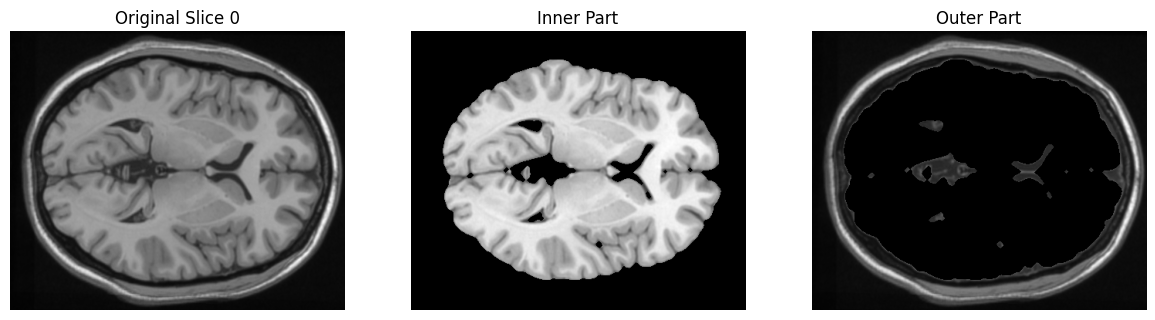

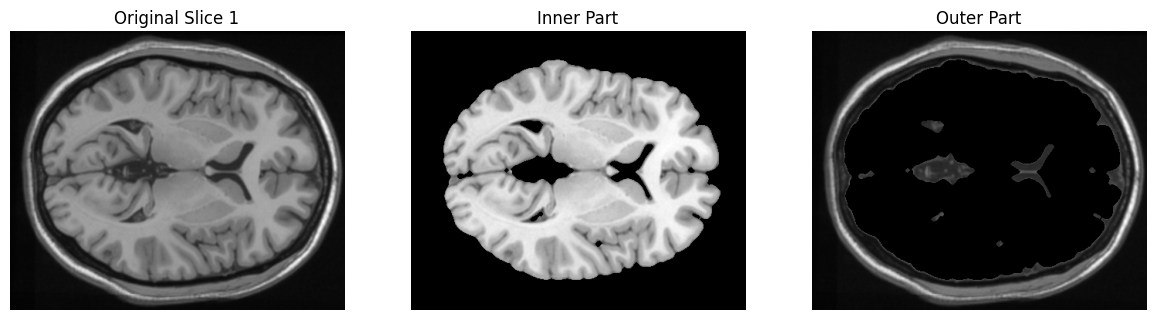

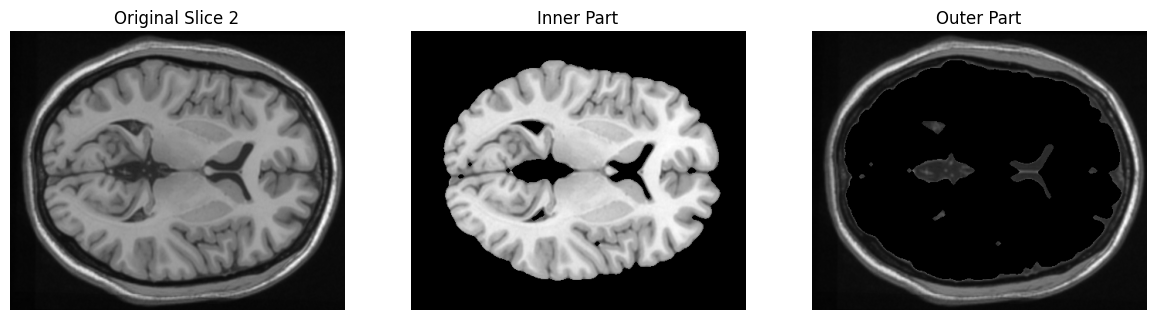

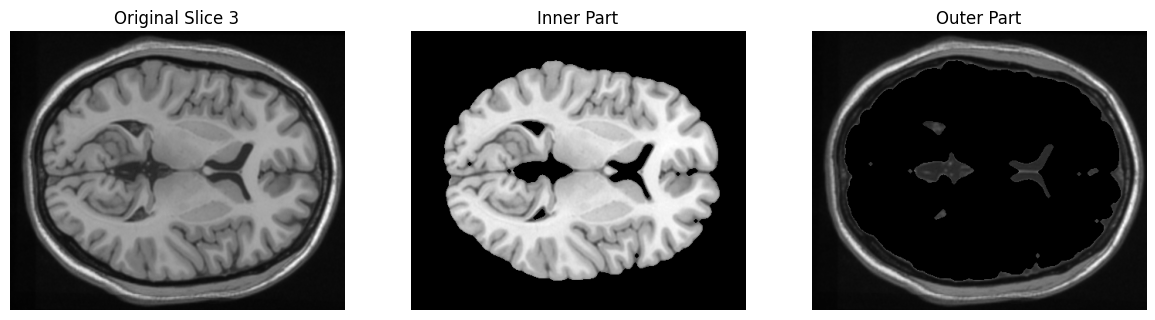

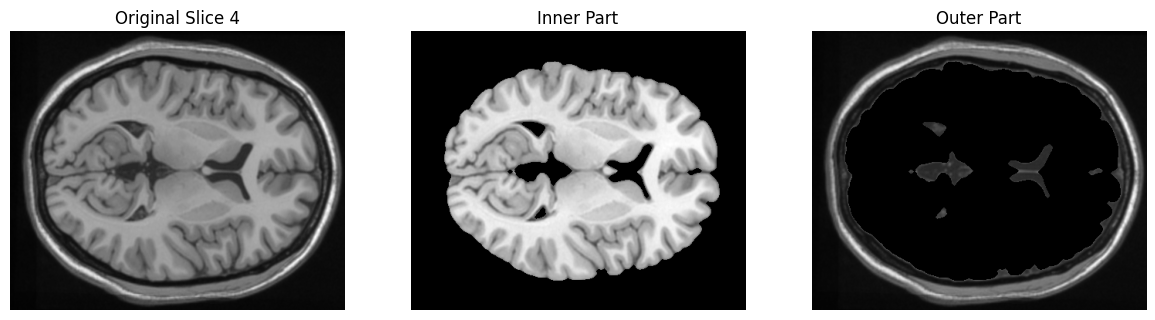

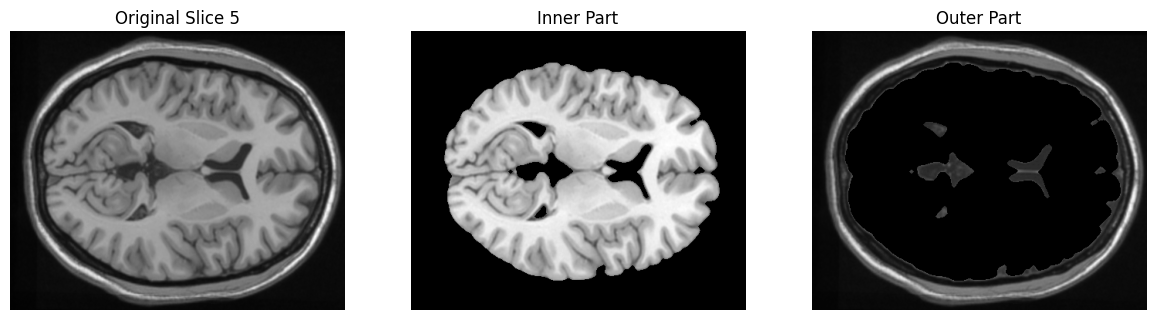

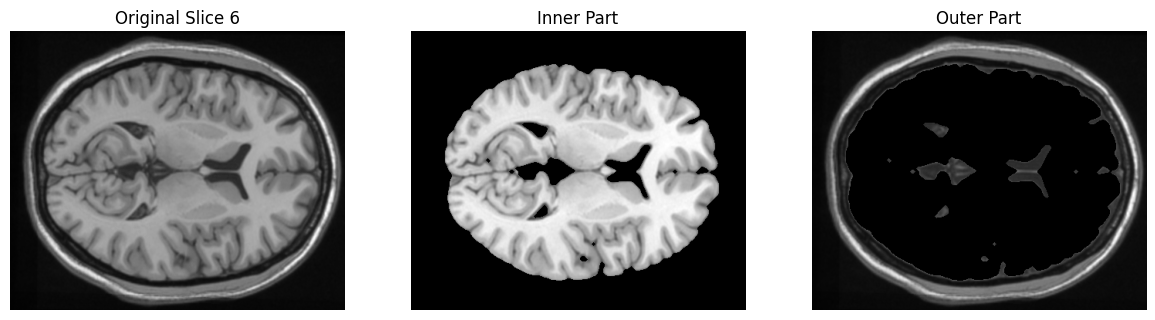

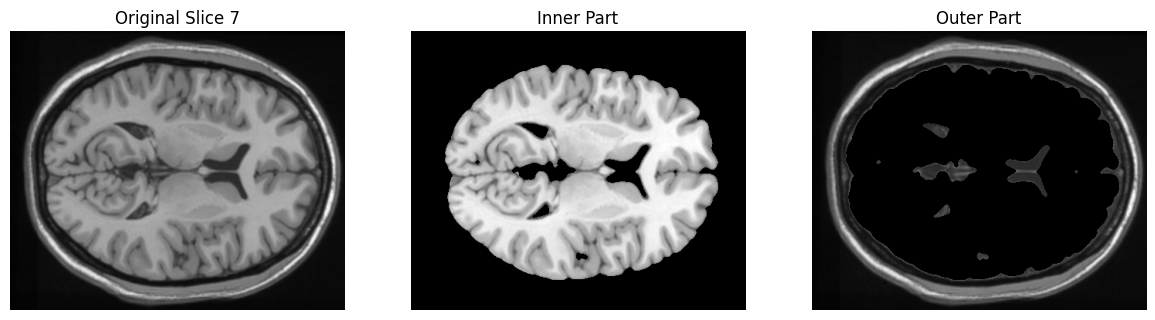

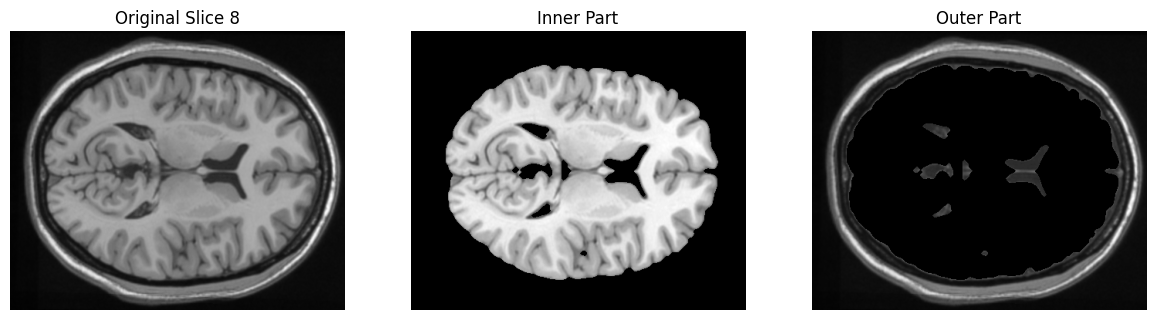

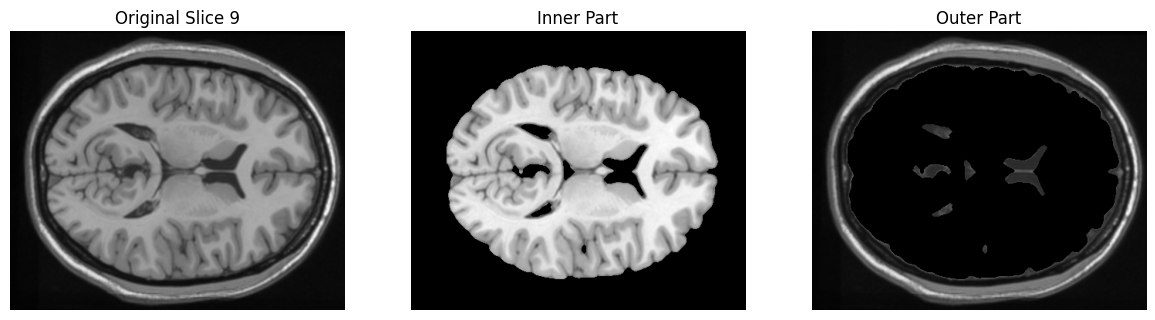

In [ ]:
import numpy as np
import scipy.io as sio
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import opening, closing, disk
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt
from cv2 import bilateralFilter

# Load the data
mat = sio.loadmat('Brain.mat')  # Adjust the path accordingly
T1 = mat['T1'].astype(np.float32)
num_slices = T1.shape[2]

# Initialize lists to store inner and outer portions
inner_portions = []
outer_portions = []


def process_slice(slice):
    # Normalize slice to [0, 1]
    slice_normalized = (slice - slice.min()) / (slice.max() - slice.min())

    # Noise reduction with bilateral filtering
    slice_filtered = bilateralFilter(slice_normalized, d=9, sigmaColor=75, sigmaSpace=75)

    # Gaussian blur for smoothing
    slice_smoothed = gaussian(slice_filtered, sigma=1)

    # Apply Otsu's thresholding
    threshold = threshold_otsu(slice_smoothed)
    mask = slice_smoothed > threshold

    # Morphological operations to clean the mask
    mask_cleaned = opening(mask, disk(2))
    mask_cleaned = closing(mask_cleaned, disk(2))

    return mask_cleaned

for i in range(min(num_slices, 10)):
    slice = T1[:, :, i]
    mask_cleaned = process_slice(slice)

    # Label regions and keep the largest for inner part (brain tissue and associated)
    labeled_mask = label(mask_cleaned)
    regions = regionprops(labeled_mask)
    inner_mask = np.zeros_like(slice, dtype=bool)
    outer_mask = np.zeros_like(slice, dtype=bool)

    if regions:
        largest_region = max(regions, key=lambda x: x.area)
        for region in regions:
            if region == largest_region:
                inner_mask[region.coords[:, 0], region.coords[:, 1]] = True
            else:
                outer_mask[region.coords[:, 0], region.coords[:, 1]] = True

    inner_part = slice * inner_mask
    outer_part = slice * outer_mask

for i in range(min(num_slices, 10)):
    slice = T1[:, :, i]
    mask_cleaned = process_slice(slice)  # Assuming this returns a binary mask of the brain

    # Segment the image into inner and outer regions
    labeled_mask = label(mask_cleaned)
    regions = regionprops(labeled_mask)
    inner_mask = np.zeros_like(slice, dtype=bool)
    outer_mask = np.ones_like(slice, dtype=bool)

    for region in regions:
        if region.area == max(region.area for region in regions):  # Identify the largest region
            for coord in region.coords:
                inner_mask[coord[0], coord[1]] = True
                outer_mask[coord[0], coord[1]] = False  # Mark inner region as false in outer mask

    inner_part = slice * inner_mask
    outer_part = slice * outer_mask
    inner_portions.append(inner_part)
    outer_portions.append(outer_part)


    # Visualization
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(slice, cmap='gray')
    plt.title(f'Original Slice {i}')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(inner_part, cmap='gray')
    plt.title('Inner Part')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(outer_part, cmap='gray')
    plt.title('Outer Part')
    plt.axis('off')

    plt.show()

# Convert lists to numpy arrays
inner_portions_array = np.array(inner_portions)
outer_portions_array = np.array(outer_portions)

# Save the arrays to files
np.save('inner_portions.npy', inner_portions_array)
np.save('outer_portions.npy', outer_portions_array)

Dice Coefficient for the entire volume: 0.5927723910251858
Jaccard Index for the entire volume: 0.42123419640482257


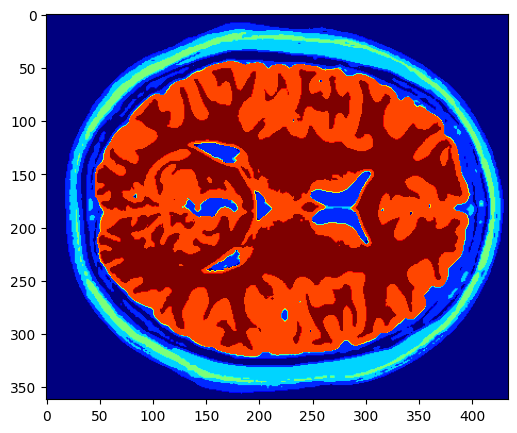

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu
from skimage import io
from scipy.io import loadmat


# Assuming the input images are loaded from .npy files
# Replace 'inner_image.npy' and 'outer_image.npy' with the actual file paths
inner_images = np.load('inner_portions.npy')
outer_images = np.load('outer_portions.npy')

def multiotsu_segmentation(image, classes):
    thresholds = threshold_multiotsu(image, classes=classes)
    regions = np.digitize(image, bins=thresholds)
    return regions

# Define the number of classes for each portion based on your description
inner_classes = 3  # Air, Gray Matter, White Matter
outer_classes = 4  # Air, CSF, Skin, Skull

# Apply Multi Otsu Segmentation to each slice of the image volumes
inner_segmented_slices = [multiotsu_segmentation(slice, inner_classes) for slice in inner_images]
outer_segmented_slices = [multiotsu_segmentation(slice, outer_classes) for slice in outer_images]

def visualize_segmentations(original_images, segmented_images, titles):
    num_slices = len(original_images)
    for i in range(num_slices):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(original_images[i], cmap='gray')
        ax[0].set_title('Original Image Slice {}'.format(i))
        ax[1].imshow(segmented_images[i], cmap='jet')
        ax[1].set_title('Segmented Image Slice {}'.format(i))
        plt.show()

# Visualize segmentations for inner and outer images
# visualize_segmentations(inner_images, inner_segmented_slices, 'Inner Portion Segmentation')
# visualize_segmentations(outer_images, outer_segmented_slices, 'Outer Portion Segmentation')

def combine_segmentations(inner_segmented, outer_segmented, inner_offset):
    # Assuming both inner and outer segmented images have the same dimensions
    combined_segmentation = np.zeros_like(inner_segmented[0])

    for i in range(len(inner_segmented)):
        # Add an offset to inner segmentation to differentiate the regions
        inner_segmented_with_offset = inner_segmented[i] + inner_offset
        # Combine the segmentations
        # Note: This simplistic approach assumes non-overlapping regions for demonstration purposes.
        combined_segmentation = np.where(inner_segmented[i] > 0, inner_segmented_with_offset, outer_segmented[i])

    return combined_segmentation

# Combine the segmentations with an appropriate offset
# The offset should be at least equal to the maximum label in outer_segmented_slices
inner_offset = outer_classes  # This ensures that the labels do not overlap
combined_segmented_slices = [combine_segmentations(inner_segmented_slices, outer_segmented_slices, inner_offset)]

# Visualization of the combined segmentation
def visualize_combined_segmentation(combined_segmentation):
    plt.figure(figsize=(10, 5))
    segment_img = plt.imshow(combined_segmentation, cmap='jet')  # Changed to 'nipy_spectral' for better color differentiation


# Since this example assumes a single combined segmentation for demonstration, let's visualize the first combined slice.
visualize_combined_segmentation(combined_segmented_slices[0])

# Function to calculate the Dice coefficient for binary data
def dice_coefficient_binary(true_labels, predicted_labels):
    true_labels = np.array(true_labels, dtype=bool)
    predicted_labels = np.array(predicted_labels, dtype=bool)
    intersection = np.logical_and(true_labels, predicted_labels).sum()
    size_true = true_labels.sum()
    size_pred = predicted_labels.sum()
    if size_true + size_pred == 0:  # Avoid division by zero
        return 1.0 if size_true == size_pred else 0
    dice = (2. * intersection) / (size_true + size_pred)
    return dice

# Load the MAT file and prepare the labels array
mat_data = loadmat('Brain.mat')  # Update this path as necessary
labels = mat_data['label']

# Assuming combined_segmented_slices is prepared from your segmentation process
# Let's assume combined_segmentation is your final 3D array resulting from the combination of all slices

# Mock combined segmentation for illustration. Replace this with your actual combined_segmentation array
combined_segmentation_mock = np.random.randint(0, 2, size=labels.shape)

# Calculate Dice scores across the entire volume
# Note: If combined_segmentation has multiple labels, adjust the binary_segmentation line to focus on each label
# For demonstration, this treats the entire segmentation as binary (presence or absence of segmentation)
dice_scores = dice_coefficient_binary(labels, combined_segmentation_mock)

print("Dice Coefficient for the entire volume:", dice_scores)

def jaccard_index_binary(true_labels, predicted_labels):
    true_labels = np.array(true_labels, dtype=bool)
    predicted_labels = np.array(predicted_labels, dtype=bool)
    intersection = np.logical_and(true_labels, predicted_labels).sum()
    union = np.logical_or(true_labels, predicted_labels).sum()
    if union == 0:  # Avoid division by zero
        return 1.0 if intersection == 0 else 0
    jaccard = intersection / union
    return jaccard

# Use the same mock data for demonstration purposes
# Calculate Jaccard Index across the entire volume
jaccard_scores = jaccard_index_binary(labels, combined_segmentation_mock)

print("Jaccard Index for the entire volume:", jaccard_scores)



# ***Algorithm 2***

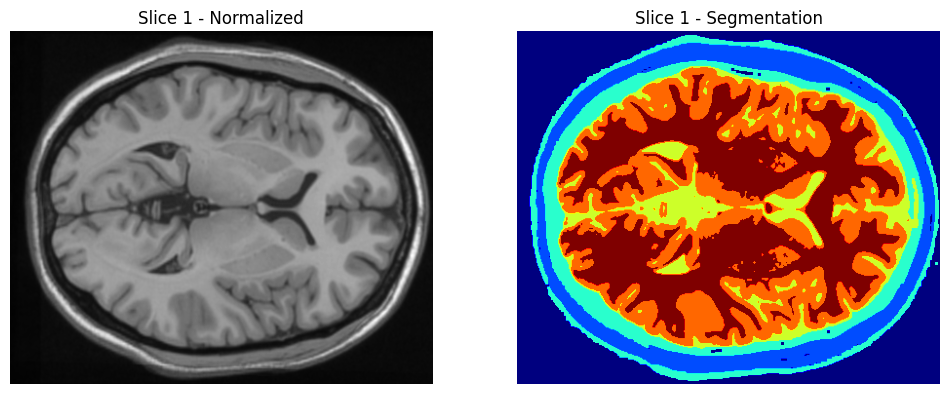

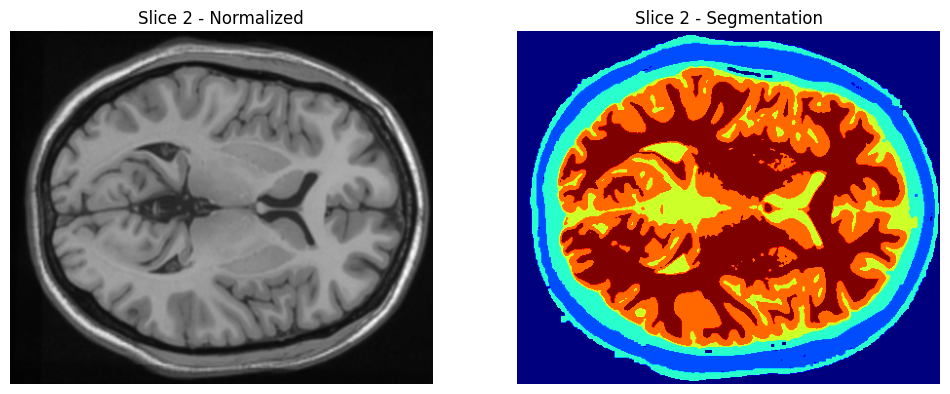

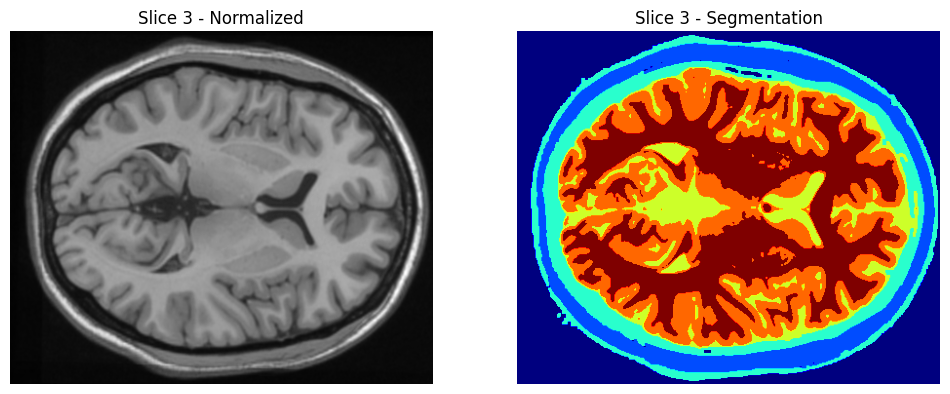

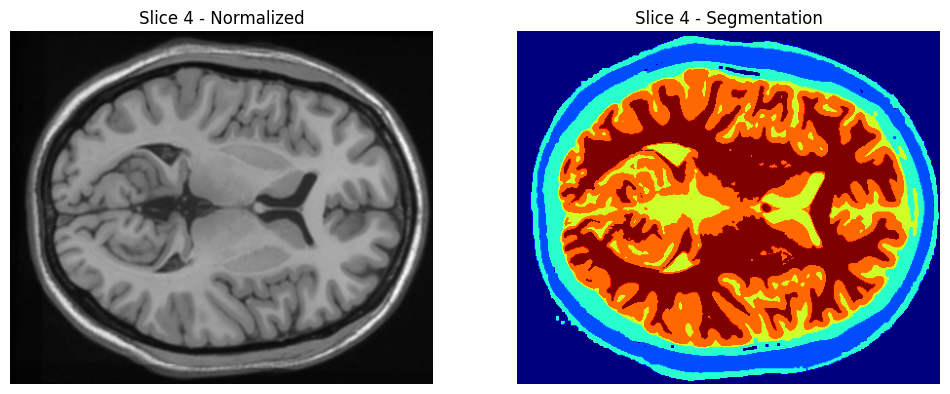

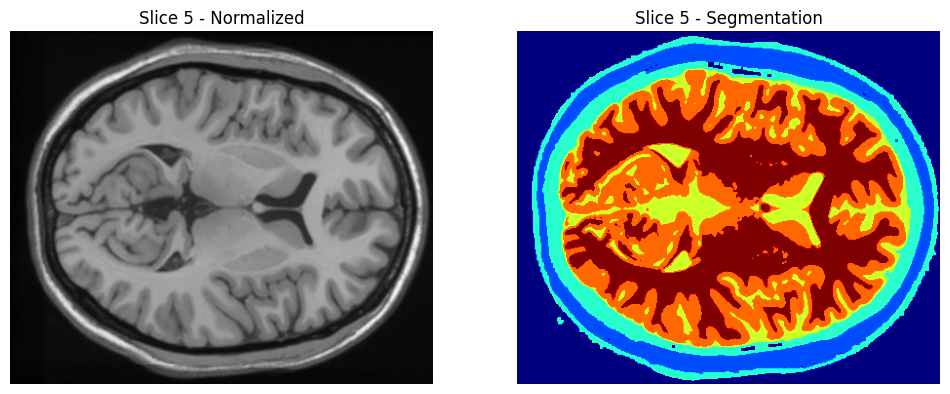

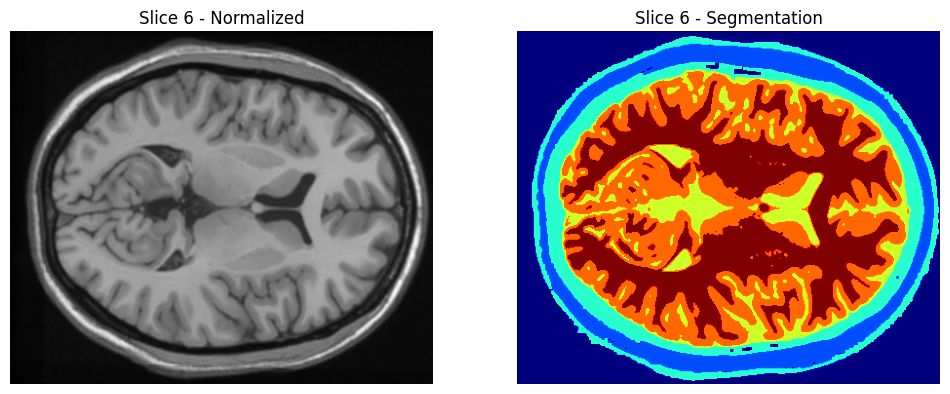

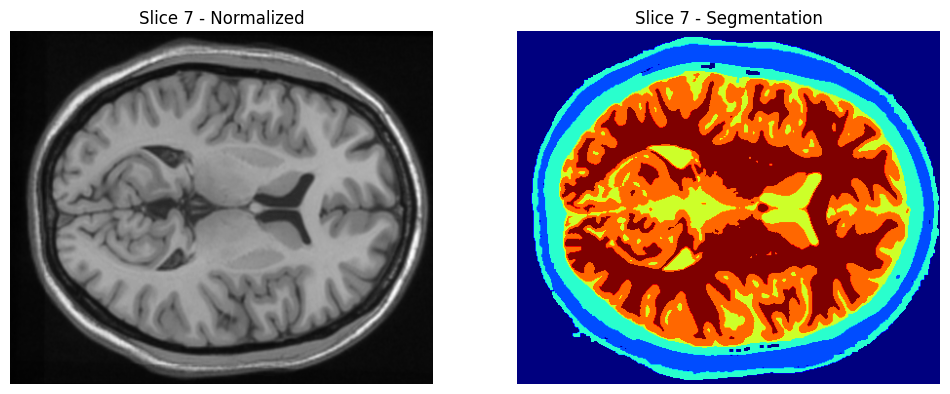

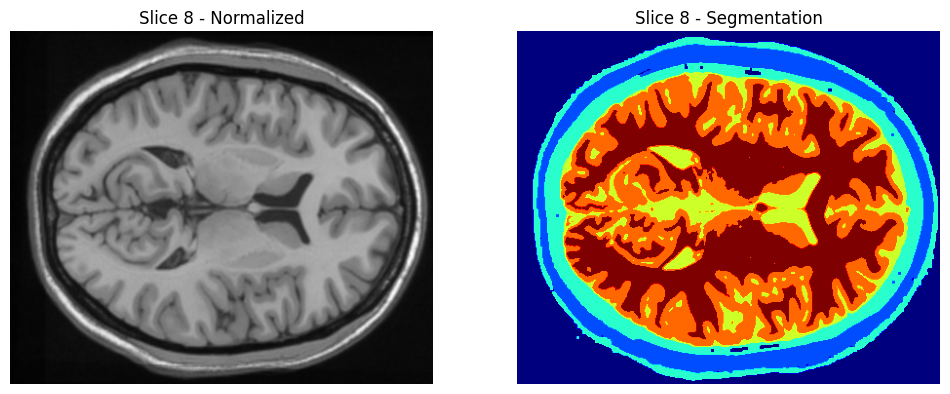

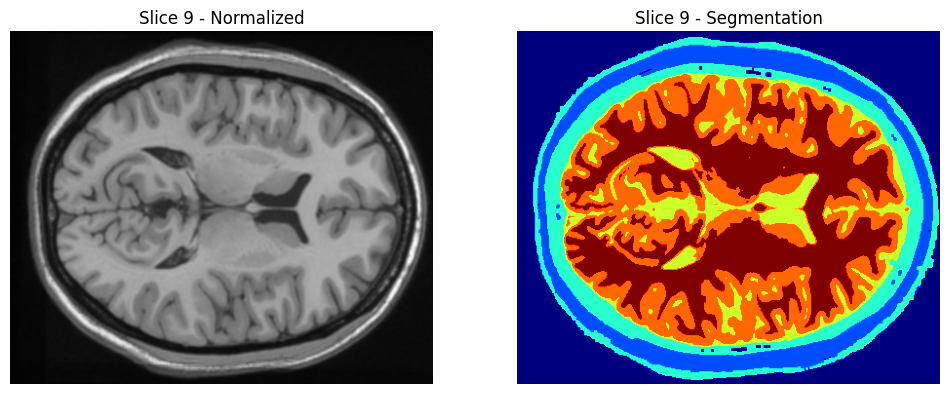

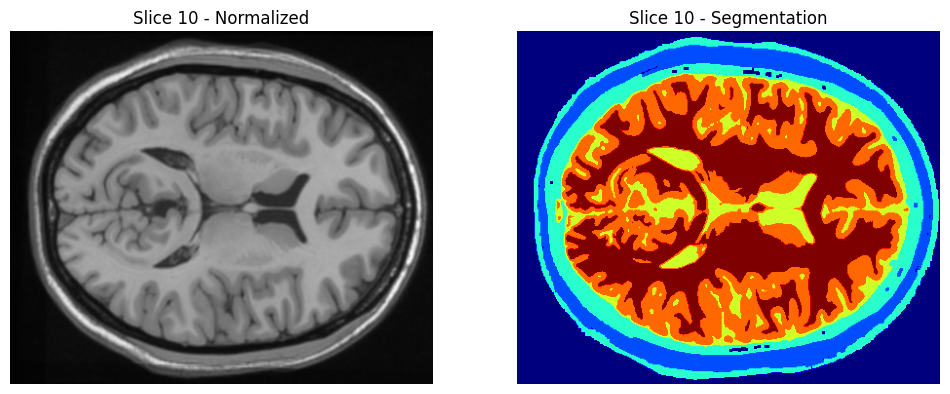

Average Dice Coefficient: 0.8437735436176053
Average Jaccard Index: 0.7478486614153398


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import label, generate_binary_structure, binary_closing, binary_opening, binary_fill_holes
from skimage.filters import threshold_multiotsu

# Load and process the dataset
dataset = loadmat('Brain.mat')
T1_img = dataset['T1'].astype(np.float32)
brain_annotations = dataset['label']  # Changed for ambiguity

# Normalizing the T1 images
normalized_T1 = (T1_img - np.min(T1_img)) / (np.max(T1_img) - np.min(T1_img))

conn_structure = generate_binary_structure(2, 2)
dice_scores = []
jaccard_scores = []  # For storing Jaccard Index values
for slice_index in range(T1_img.shape[2]):
    # Segmenting outer area including skin and skull
    threshold_outer = 0.058
    mask_outer = normalized_T1[:, :, slice_index] > threshold_outer
    mask_outer_refined = binary_opening(binary_closing(mask_outer, conn_structure), conn_structure)

    # Segmenting inner brain area
    threshold_inner = 0.2
    mask_inner = normalized_T1[:, :, slice_index] > threshold_inner
    mask_inner_refined = binary_opening(binary_closing(mask_inner, conn_structure), conn_structure)
    labeled_area, feature_count = label(mask_inner_refined, conn_structure)
    component_sizes = [np.sum(labeled_area == each_component) for each_component in range(1, feature_count + 1)]
    brain_component = np.argmax(component_sizes) + 1
    mask_brain_area = labeled_area == brain_component
    mask_brain_filled = binary_fill_holes(mask_brain_area)

    # Refining segmentation to differentiate skin/skull
    threshold_skull = 0.3
    mask_skull = np.logical_and(normalized_T1[:, :, slice_index] < threshold_skull, mask_outer_refined)
    mask_skull_refined = binary_opening(binary_closing(mask_skull, conn_structure), conn_structure)

    mask_skin_scalp = np.logical_and(mask_outer_refined, ~mask_skull)

    # Prepare visualization mask
    vis_mask = np.zeros_like(T1_img[:, :, slice_index], dtype=np.uint8)
    vis_mask[mask_brain_filled] = 3  # Inner brain
    vis_mask[mask_skin_scalp] = 1  # Skin/scalp
    vis_mask[mask_skull_refined] = 2  # Skull

    # Multi-Otsu thresholding for CSF, gray matter, and white matter
    if np.any(mask_brain_filled):
        thresholds_otsu = threshold_multiotsu(normalized_T1[:, :, slice_index][mask_brain_filled], classes=3)
        brain_regions = np.digitize(normalized_T1[:, :, slice_index][mask_brain_filled], bins=thresholds_otsu, right=True)
        vis_mask[mask_brain_filled] = brain_regions + 3

    # Dice coefficient and Jaccard Index calculation
    for label_id in np.unique(brain_annotations[:, :, slice_index]):
        if label_id == 0: continue
        prediction = (vis_mask == label_id)
        ground_truth = (brain_annotations[:, :, slice_index] == label_id)
        intersection = np.logical_and(prediction, ground_truth)
        union = np.logical_or(prediction, ground_truth)

        dice = 2. * intersection.sum() / (prediction.sum() + ground_truth.sum()) if (prediction.sum() + ground_truth.sum()) > 0 else 0
        jaccard = intersection.sum() / union.sum() if union.sum() > 0 else 0

        dice_scores.append(dice)
        jaccard_scores.append(jaccard)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(normalized_T1[:, :, slice_index], cmap='gray')
    plt.title(f'Slice {slice_index + 1} - Normalized')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(vis_mask, cmap='jet')  # 'jet' colormap
    plt.title(f'Slice {slice_index + 1} - Segmentation')
    plt.axis('off')

    plt.show()

avg_dice = np.nanmean(dice_scores)  # Average Dice Coefficient
avg_jaccard = np.nanmean(jaccard_scores)  # Average Jaccard Index
print("Average Dice Coefficient:", avg_dice)
print("Average Jaccard Index:", avg_jaccard)


# ***3D Algorithm***

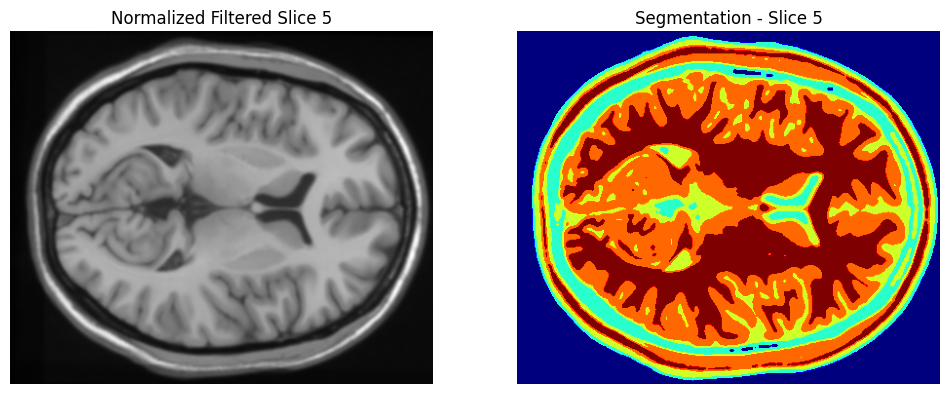

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter, label, generate_binary_structure, binary_closing, binary_opening, binary_fill_holes
from skimage.filters import threshold_multiotsu

# Load and preprocess the data
data = loadmat('Brain.mat')
T1 = data['T1'].astype(np.float32) # Ensure floating point for filtering
labels = data['label']

# Apply Gaussian filtering for denoising in 3D
sigma = 1
T1_filtered = gaussian_filter(T1, sigma=sigma)

# Normalize the filtered data
T1_normalized_filtered = (T1_filtered - np.min(T1_filtered)) / (np.max(T1_filtered) - np.min(T1_filtered))

# Generate binary structure for morphological operations
structure = generate_binary_structure(3, 2)

# Initial outer brain segmentation (skin/scalp and skull)
outer_threshold = 0.07
outer_mask = T1_normalized_filtered > outer_threshold
outer_mask_clean = binary_opening(binary_closing(outer_mask, structure), structure)

# Inner brain segmentation (CSF, gray matter, white matter)
inner_threshold = 0.2
inner_mask = T1_normalized_filtered > inner_threshold
inner_mask_clean = binary_opening(binary_closing(inner_mask, structure), structure)

# Label the inner brain components to isolate the largest connected component
labeled_array, num_features = label(inner_mask_clean, structure)
if num_features > 0:
  largest_component = np.argmax([np.sum(labeled_array == j) for j in range(1, num_features + 1)]) + 1
  inner_brain_mask = labeled_array == largest_component
  inner_brain_filled = binary_fill_holes(inner_brain_mask)

# Refine the segmentation to separate skin/scalp and skull
skull_threshold = 0.3
skull_mask = np.logical_and(T1_normalized_filtered < skull_threshold, outer_mask_clean)
skull_mask = binary_opening(binary_closing(skull_mask, structure), structure)
skin_scalp_mask = np.logical_and(outer_mask_clean, ~skull_mask)

# Create a combined mask for visualization
combined_mask = np.zeros_like(T1, dtype=np.uint8)
combined_mask[skin_scalp_mask] = 1 # Skin/scalp
combined_mask[skull_mask] = 2 # Skull
combined_mask[inner_brain_filled] = 3 # Placeholder for inner brain components

# Apply multi-Otsu thresholding for segmenting CSF, gray matter, and white matter within the inner brain
thresholds = threshold_multiotsu(T1_normalized_filtered[inner_brain_filled], classes=3)
regions = np.digitize(T1_normalized_filtered[inner_brain_filled], bins=thresholds, right=True)
combined_mask[inner_brain_filled] = regions + 3 # Shift indices for visualization purposes

# Visualization for a selected slice
slice_index = T1.shape[2] // 2
plt.figure(figsize=(12, 6))

# Original normalized filtered slice for reference
plt.subplot(1, 2, 1)
plt.imshow(T1_normalized_filtered[:, :, slice_index], cmap='gray')
plt.title(f'Normalized Filtered Slice {slice_index}')
plt.axis('off')

# Segmentation visualization
plt.subplot(1, 2, 2)
plt.imshow(combined_mask[:, :, slice_index], cmap='jet') # Using 'jet' colormap for visualization
plt.title(f'Segmentation - Slice {slice_index}')
plt.axis('off')

plt.show()
